<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Gavrilkov%20Nikolay/internship_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1-я стажировка "Профпатолог" - 5 неделя


In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop

#from tensorflow.keras.metrics import *

!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons import metrics

#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
# Дополнительные инструменты
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

from google.colab import data_table
data_table.enable_dataframe_formatter()

import random 
import math 
import os 
import re 
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 5.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Создадим несколько процедур для анализа данных датасета

In [ ]:
# Для вывода подробной информации по колонке если послетдний параметр True - выведет количетвенное распределения по значениям в колонке.
def info_col (row, df, x=False):
    print(f'Заполнено: {df[row].count()} ячеек ({round(df[row].count()*100/df.shape[0],2)}%), уникальных записей: {df[row].nunique()}')
    if x :
        print(df[row].unique())
    else:
        print(df[row].value_counts())
    print('Тип данных: ', df[row].dtypes)
    return   

In [ ]:
# Проверка влияния значения в колонеке на конечный результат
def viev_row(row, val, rows = []):
    rowses = list(['ЗаключениеМК'])
    rowses.extend(rows)
    if row not in rowses:
        rowses.append(row)
    display(df_cor[(df_cor[row] == val)][rowses])
    return
            

In [ ]:
# небольшая ф-ция по слиянию колонок, содержащих одинаковые данные т.е. если в целевой колонке строка не заполнена, а в одной из
# колонок из списка имеются данные, они будут скопированы в целевую колонку.
def col_concat (row, list_row):
    for row1 in list_row:
        print(f'{row} было заполнено - {df_cor[row].count()}')
        df_cor.loc[df_cor[row].isna(),[row]] = df_cor[row1]
        print(f'{row} + {row1} стало - {df_cor[row].count()}')
    return

## Загрузка и предварительная обработка

In [ ]:
df_stock = pd.read_csv('/content/drive/MyDrive/profpatolog/df_stock.csv')
df_stock.head()

<ipython-input-6-69eee24b1f17>:1: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,109,113,121,123,125,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,259,261,263,265,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,324,326,328,330,331,332,334,336,338,340,342,344,346,348,350,351,352,353,354,355,356,363,364,365,366,367,370,393,395,397,399,401,403,405,406,407,419,434,435,436,437,438,439,440,441,442,443,444,445,447,449,451,453,455,457,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,579,581,585,587,589,591,593,595,597,599,601,603,605,607,609,611,613,615,617,619,621,623,625,627,629,631,634,635,637,644,645,646,647,648,651,652,653,654,655,681,682,683,693,694,701,702,703,705,708,709,710,711,712,786,787,788,789,800,806,807,808,8

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b8a33910-8eec-11ec-80fe-0cc47aab8067,98f9d761-8d65-11ec-80fe-0cc47aab8067,1988-04-25,Мужской,Мужской,2022-02-16,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0bb0d181-938c-11ec-80fe-0cc47aab8067,009aac7d-7bcf-11eb-80e8-0cc47aab8067,1984-04-17,Мужской,Мужской,2022-02-22,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_stock.to_csv('/content/drive/MyDrive/profpatolog/df_stock.csv', index=False)

In [ ]:
df_stock.isna().sum().sum()

8106978

In [ ]:
# Процент незаполненных ячеек во всем датасете.
df_stock.isna().sum().sum() *100 / df_stock.size

89.17160923128299

In [ ]:
df_stock.shape

(1982, 4587)

In [ ]:
df_cor = df_stock.copy()

In [ ]:
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor.csv', index=False)

In [ ]:
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor.csv')

<ipython-input-75-4db4f9bf01f7>:1: DtypeWarning: Columns (9,10,16,17,27,29,105,106,107,108,109,112,119,120,160,161,162,163,181,186,286,287,290,291,294,295,337,349,350,352,353,354,355,356,357,360,361,370,397,398,423,424,425,426,427,428,439,440,465,466,471,472,501,502,507,508,577,578,581,582,591,592,617,618,621,622,641,642,651,652,663,664,669,670,679,680,705,706,729,730,765,766,767,768,800,801,808,809,810,811,816,817,818,819,822,823,824,825,830,831,832,833,838,839,849,853,854,855,856,857,858,859,860,861,862,863,866,867,874,875,876,877,878,879,880,881,882,883,884,885,886,887,904,905,908,909,911,914,915,916,917,918,919) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor.csv')


In [ ]:
df_cor.shape

(1982, 4587)

In [ ]:
# Анализ целевого столбца "ЗаключениеМК"
print(f"заполненных строк - {df_cor['ЗаключениеМК'].count()}, не заполнено - {df_cor['ЗаключениеМК'].isna().sum()}")
print(f"Количество уникальных записей - {df_cor['ЗаключениеМК'].nunique()}")
df_cor['ЗаключениеМК'].unique()

заполненных строк - 1575, не заполнено - 407
Количество уникальных записей - 9


array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель',
       ' Газоспасатель'], dtype=object)

In [ ]:
#Удалим строки с ошибками заполнения ('машинист бульдозера', 'Газоспасатель',' Газоспасатель')
count_ind = df_cor.shape[0]
for str1 in ('машинист бульдозера', 'Газоспасатель',' Газоспасатель'):
    df_cor = df_cor.drop(df_cor[df_cor['ЗаключениеМК'] == str1].index)
print(f'Удалено {count_ind - df_cor.shape[0]} строк(и)')
df_cor.shape

Удалено 4 строк(и)


(1978, 4587)

In [ ]:
# Строки с незаполненным столбцом 'ЗаключениеМК' выделим в отдельный датафрейм
df_NAN = df_cor[df_cor['ЗаключениеМК'].isna()]
df_NAN.shape

(407, 4587)

In [ ]:
 # Удалим строки из основного набора
df_cor = df_cor.drop(df_cor[df_cor['ЗаключениеМК'].isna()].index)
df_cor.shape

(1571, 4587)

In [ ]:
df_cor['ЗаключениеМК'].value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

In [ ]:
# Приведение к 3 классам методом map()
new_val = {'ГоденСКоррекциейЗрения':'ОграниченноГоден','ГоденБезРаботНаВысотах':'ОграниченноГоден','НуждаетсяВДообследованииИЛечении':'НеГоден','ВременноНегоден':'НеГоден','Годен':'Годен','ОграниченноГоден':'ОграниченноГоден'}
df_cor['ЗаключениеМК'] = df_cor['ЗаключениеМК'].map(new_val)

In [ ]:
df_cor['ЗаключениеМК'].value_counts()

Годен               1434
ОграниченноГоден     126
НеГоден               11
Name: ЗаключениеМК, dtype: int64

In [ ]:
#Удалим колонки не имеющие записей
print(f'Размер до - {df_cor.shape}')
df_cor = df_cor.dropna(axis=1, how='all')
print(f'Размер после - {df_cor.shape}')

Размер до - (1571, 4587)
Размер после - (1571, 3578)


In [ ]:
# процет незаполненных ячеек
df_cor.isna().sum().sum() * 100 / df_cor.size

85.91155227913421

In [ ]:
# создадим список колонок датафрейма.
cols_list = df_cor.columns.tolist()
len(cols_list)

3578

In [ ]:
cols_list[:20]

['ДокументПрохождениеМедосмотра',
 'Клиент',
 'КлиентДатаРождения',
 'КлиентПол',
 'КлиентПолПредставление',
 'ДатаЗавершенияМедосмотра',
 'ТипМедосмотра',
 'ТипМедосмотраПредставление',
 'ПсихОсвидетельствование',
 'Контрагент',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ЗаключениеМКПредставление',
 'Заключение',
 'ДиспансернаяГруппа',
 'ДиспансернаяГруппаПредставление',
 'ВредныеФакторы',
 'ЛабораторныеИсследования1_ДокументПрием',
 'ЛабораторныеИсследования1_ДатаПриема']

In [ ]:
info_col('Рентгенология2_Заключение_ЗначениеПредставление', df_cor, True)

Заполнено: 3 ячеек (0.19%), уникальных записей: 1
[nan 'без патологий']
Тип данных:  object


In [ ]:
# Составим список учитываемых колонок
selected_col = ['КлиентДатаРождения','ДатаЗавершенияМедосмотра','КлиентПол','Профессия','ЗаключениеМК','ДиспансернаяГруппа',
           'ВредныеФакторы','Терапия1_П_Значение','Терапия1_ЧССТерапевт_Значение']

In [ ]:
# Добавим некоторые колонки по условию
for elem in cols_list:
    if ('Рекомендация' in elem and 'Представление' in elem) or 'РекомендацияСтр' in elem:       # Добавим колони с рекомендациями
        selected_col.append(elem)
        continue
    if 'МКБ' in elem or 'Детализация' in elem:                  # Колонки с кодами МКБ и Детализация
        selected_col.append(elem)
        continue
    if 'Противопоказание' in elem and 'Представление' in elem:   # Противопоказания 
        selected_col.append(elem)
        continue
    if 'Профнепригодность' in elem and 'Представление' in elem:  # Профнепригодность
        selected_col.append(elem)
        continue
    if 'Диагноз' in elem and 'Представление' in elem:            # Диагнозы
        selected_col.append(elem)
        continue
    if 'ГоденНегоден' in elem and 'Представление' in elem:      # ГоденНегоден
        selected_col.append(elem)
        continue
    if 'Анамнез' in elem and 'Представление' in elem:           # Анамнез
        selected_col.append(elem)
        continue
    if 'Аудиометрия' in elem and 'Представление' in elem:       # Аудиометрия
        selected_col.append(elem)
        continue
    if 'Заключение_' in elem and 'Представление' in elem:       # Заключения по специалистам если такие есть.   
        selected_col.append(elem)
        continue
# колонки содержащие цировые данные (могут иметь тип не floan и int - преобразовывать будем потом)        
    if 'АртериальноеДавление' in elem and 'Представление' in elem:    #      
        selected_col.append(elem)
        continue
    if 'Температура' in elem and 'Представление' in elem:          #
        selected_col.append(elem)
        continue
    if 'Сатурация' in elem and 'Представление' in elem:          #
        selected_col.append(elem)
        continue
    if 'ИМТ' in elem and 'Представление' in elem:          #
        selected_col.append(elem)
        continue

print(len(selected_col))
print(selected_col[:5])

481
['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра', 'КлиентПол', 'Профессия', 'ЗаключениеМК']


In [ ]:
# Сократим датафрейм до отобранных колонок.
df_cor = df_cor[selected_col]
df_cor.shape

(1571, 481)

In [ ]:
# Проверка результата: создадим таблицу содержащую данные по заполненности колонки, количеству уникальных значений, и типу данных
counts = df_cor.count(axis=0)
uniques = df_cor.nunique(axis=0)
types = df_cor.dtypes
df_x = pd.concat([counts.to_frame(name='count'), uniques.to_frame(name='unique'), types.to_frame(name='type')], axis= 1 )

In [ ]:
df_x

,count,unique,type
КлиентДатаРождения,1571,1426,object
ДатаЗавершенияМедосмотра,1571,84,object
КлиентПол,1571,2,object
Профессия,1571,557,object
ЗаключениеМК,1571,3,object
...,...,...,...
Оториноларингология3_ПрофнепригодностьВременнаяПредставление1,1,1,object
Оториноларингология3_ГоденНегоден_ЗначениеПредставление,1,1,object
Оториноларингология3_Анамнез_ЗначениеПредставление,1,1,object
Оториноларингология3_Диагноз_ЗначениеПредставление,1,1,object


In [ ]:
# Удалим колонки с одной записью 
del_col = list(df_x[(df_x['count'] == 1)].index)
print(len(del_col))
df_cor = df_cor.drop(del_col, axis=1)
df_cor.shape

30


(1571, 451)

In [ ]:
# Визуализируем влияние некоторых колонок на колонку "ЗаключениеМК"
rowses = ['Терапия1_ГоденНегоден_ЗначениеПредставление','Терапия1_П_Значение','Неврология1_ГоденНегоден_ЗначениеПредставление']
viev_row('Терапия1_ИМТ_ЗначениеПредставление','НетДанных', rowses)

,ЗаключениеМК,Терапия1_ГоденНегоден_ЗначениеПредставление,Терапия1_П_Значение,Неврология1_ГоденНегоден_ЗначениеПредставление,Терапия1_ИМТ_ЗначениеПредставление


In [ ]:
# Выведем колонки заполненные 1 значением
rez_col = list(df_x[(df_x['unique'] == 1)].index)
print(len(rez_col))
print(rez_col)

239
['Рентгенология1_Заключение_ЗначениеПредставление', 'ПсихиатрияНаркология1_ПротивопоказаниеПредставление1', 'Офтальмология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология1_Анамнез_ЗначениеПредставление', 'ХирургНеИсп1_МКБ101', 'ХирургНеИсп1_ДиагнозПредставление1', 'ХирургНеИсп1_ПрофнепригодностьВременнаяПредставление1', 'ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление', 'ХирургНеИсп1_Анамнез_ЗначениеПредставление', 'ХирургНеИсп1_Диагноз_ЗначениеПредставление', 'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 'Стоматология1_ГоденНегоден_ЗначениеПредставление', 'Стоматология1_Анамнез_ЗначениеПредставление', 'Дерматовенерология1_ХР_Рекомендация1Представление', 'Дерматовенерология1_ХР_Рекомендация2Представление', 'Дерматовенерология1_ГоденНегоден_ЗначениеПредставление', 'Дерматовенерология1_Анамнез_ЗначениеПредставление', 'Рентгенология1_МКБ101', 'Рентгенология1_ДиагнозПредставление1', 'Рентгенология1_Профне

In [ ]:
# Сохранение промежуточных результатов фильтрации
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_1.csv', index=False)

## 2-й этап

In [ ]:
# Загрузка сохраненных ранее датафреймов
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_1.csv')

In [ ]:
df_cor.shape

(1571, 451)

In [ ]:
cols_list = df_cor.columns.tolist()
len(cols_list)

451

In [ ]:
# Объединение родственных колонок по специалистам, используя написанную вначале процедуру col_concat()
# с последующим удалением использованных колонок.
lst_par1 = ['Терап','Хирург','Гинеколог','Стоматолог','Дермато','Психиатр','Невролог','Офтальмолог','Оториноларинголог',
            'Рентгенолог','УЗИ','Лаборатор','Процедур','Эндоскоп','Функционал']
lst_par2 = ['Рекомендация','МКБ','ИМТ','Детализация','Профнепригодность','ГоденНегоден','Диагноз','Анамнез','Аудиометрия',
            'АртериальноеДавление_','Температура','Сатурация','АртериальноеДавление21']
for elm1 in lst_par1:
    cols1_list = df_cor.columns.tolist()  # Пересоздаем список колонок чтобы исключить удаленные
    tst_list = []
    for elm in cols1_list:
        if elm1 in elm:
            tst_list.append(elm)
    for elm2 in lst_par2:
        conc_list = []
        for elm in tst_list:
            if elm2 in elm:
                conc_list.append(elm)
        if len(conc_list) > 1:
            row_con = conc_list.pop(0)
            col_concat(row_con, conc_list) 
            df_cor = df_cor.drop(conc_list, axis=1) 

print(df_cor.shape)

Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия1_ХР_Рекомендация2Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия2_ХР_Рекомендация1Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия2_ХР_Рекомендация2Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия3_ХР_Рекомендация1Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия3_ХР_Рекомендация2Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия4_ХР_Рекомендация1Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Пре

In [ ]:
# процет незаполненных ячеек
df_cor.isna().sum().sum() * 100 / df_cor.size

54.25700515725068

In [ ]:
cols_list = df_cor.columns.tolist()
selected_col = []
for elem in cols_list:
    if 'Сатурация' in elem:
        selected_col.append(elem)
counts = df_cor[selected_col].count(axis=0)
uniques = df_cor[selected_col].nunique(axis=0)
types = df_cor[selected_col].dtypes
df_y = pd.concat([counts.to_frame(name='count'), uniques.to_frame(name='unique'), types.to_frame(name='type')], axis= 1 )
df_y

,count,unique,type
Терапия1_Сатурация_ЗначениеПредставление,1191,10,float64


In [ ]:
info_col('Терапия1_Сатурация_ЗначениеПредставление', df_cor, True)

Заполнено: 1191 ячеек (75.81%), уникальных записей: 10
[  nan  97.   98.   99.   36.6  96.   95.  100.   88.   68.   94. ]
Тип данных:  float64


In [ ]:
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_2.csv', index=False)

In [ ]:
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_2.csv')

In [ ]:
# Приведем в порядок цифровые колонки 
map_x = lambda x: x if len(str(x)) <= 3 else str(x)[:3]
df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'] = df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'].map(map_x)
df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'] = df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].map(map_x)
# И переведем её в float формат
df_cor = df_cor.astype({'Терапия1_АртериальноеДавление_ЗначениеПредставление': np.float64})
df_cor = df_cor.astype({'Терапия1_АртериальноеДавление21_ЗначениеПредставление': np.float64})
df_cor.loc[df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'] > 300,['Терапия1_АртериальноеДавление21_ЗначениеПредставление']] = df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление']/10
map_y = lambda x: str(x).replace(',','.').replace('/','.').replace('..','.')
df_cor['Терапия1_Температура_ЗначениеПредставление'] = df_cor['Терапия1_Температура_ЗначениеПредставление'].map(map_y)
df_cor = df_cor.astype({'Терапия1_Температура_ЗначениеПредставление': np.float64})
df_cor = df_cor.astype({'Терапия1_Сатурация_ЗначениеПредставление': np.float64})
df_cor['Терапия1_ИМТ_ЗначениеПредставление'] = df_cor['Терапия1_ИМТ_ЗначениеПредставление'].map(map_y)
df_cor = df_cor.astype({'Терапия1_ИМТ_ЗначениеПредставление': np.float64})
print(df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].unique())
print(df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'].unique())
print(df_cor['Терапия1_Температура_ЗначениеПредставление'].unique())

[  nan  82.   80.   60.   70.   90.  110.  120.   75.   85.   84.   77.
  72.   68.   78.   83.   64.   76.   74.   86.   89.   87.   71.   88.
 112.   92.   66.  100.   62.   81.   80.1  99.   91.   97.  111.  104.
 102.   95.   98.   69.   96.  105.   73.  108.   63.  101.   93.   79.
  67.  107.  106.   94.  103.  109.   80.5  65.   61.   20.   58.   40.
  59. ]
[140. 150. 120. 110. 105. 130. 125. 133. 100. 160. 180. 115.  90. 135.
 128. 138.  nan 112. 129. 118. 155. 102. 144. 107. 141. 182. 145. 131.
 123. 193. 121. 127. 113. 132. 109. 117. 137. 124. 116. 171. 151. 142.
 134. 146. 168. 119. 111. 177. 165. 122. 153. 159. 143. 147. 148. 167.
 136. 139. 189. 166. 162. 158. 172. 169. 152. 126. 198. 161. 174. 175.
 186. 108. 106. 170. 154. 149. 173. 157. 114. 163.  95. 101.]
[ 36.4  36.5  36.6  36.3  36.2   nan  36.7  36.8  80.   97.   36.   35.
 164.   35.6]


In [ ]:
col_concat('Терапия1_П_Значение', ['Терапия1_ЧССТерапевт_Значение'])

Терапия1_П_Значение было заполнено - 1380
Терапия1_П_Значение + Терапия1_ЧССТерапевт_Значение стало - 1380


In [ ]:
df_cor = df_cor.drop(['Терапия1_ЧССТерапевт_Значение'], axis=1)

In [ ]:
# Проверка результата пересоберем df_x
counts = df_cor.count(axis=0)
uniques = df_cor.nunique(axis=0)
types = df_cor.dtypes
df_x = pd.concat([counts.to_frame(name='count'), uniques.to_frame(name='unique'), types.to_frame(name='type')], axis= 1 )

In [ ]:
df_x

,count,unique,type
КлиентДатаРождения,1571,1426,object
ДатаЗавершенияМедосмотра,1571,84,object
КлиентПол,1571,2,object
Профессия,1571,557,object
ЗаключениеМК,1571,3,object
...,...,...,...
ФункциональнаяДиагностика1_ДиагнозПредставление1,6,1,object
ФункциональнаяДиагностика1_ПрофнепригодностьВременнаяПредставление1,6,1,object
Эндоскопия1_МКБ101,4,2,object
Эндоскопия1_ДиагнозПредставление1,4,2,object


In [ ]:
dig_col = df_cor.select_dtypes(include=['float64','int64']).columns.to_list()
print(len(dig_col))

7


In [ ]:
# Дозаполним пустые ячейки (числовые ячейки заполняем нулями, для МКБ - Z00.0('Медосмотр'), текстовые данные и данные ОНЕ -  )

cols_list = df_cor.columns.tolist()
mkb_col = []
for elem in cols_list:
    if 'МКБ' in elem:
        mkb_col.append(elem)                                                   # Все колонки МКБ

dig_col = df_cor.select_dtypes(include=['float64','int64']).columns.to_list()  # Список колонок с цифровыми данными


df_cor[dig_col] = df_cor[dig_col].fillna(0)
df_cor[mkb_col] = df_cor[mkb_col].fillna('Z00.0')
df_cor = df_cor.fillna('НетДанных')                                            # Все остальные колонки 

In [ ]:
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_3.csv', index=False)

## Общий раздел

In [ ]:
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_3.csv')

In [ ]:
df_cor.shape

(1571, 97)

In [ ]:
cols_list = df_cor.columns.tolist()
len(cols_list)

97

In [ ]:
# Проверим балансировку датасета (соотношение Годен/НеГоден):
rat = len(df_cor.loc[df_cor['ЗаключениеМК']=='Годен'])//len(df_cor.loc[df_cor['ЗаключениеМК']=='НеГоден'])
print(f'Соотношение заключений Годен к НеГоден - {rat} к 1')

# Проверим балансировку датасета (соотношение Годен/ОграниченноГоден):
rat1 = len(df_cor.loc[df_cor['ЗаключениеМК']=='Годен'])//len(df_cor.loc[df_cor['ЗаключениеМК']=='ОграниченноГоден'])
print(f'Соотношение заключений Годен к ОграниченноГоден - {rat1} к 1')

Соотношение заключений Годен к НеГоден - 130 к 1
Соотношение заключений Годен к ОграниченноГоден - 11 к 1


In [ ]:
# Попробуем изменить соотношение размножив минорный класс и перемешав датасет
df_cor_x = df_cor.loc[df_cor['ЗаключениеМК']=='НеГоден']
df_cor_x = df_cor_x.loc[df_cor_x.index.repeat(rat//2)]
df_cor = pd.concat([df_cor, df_cor_x]).sample(frac=1)
print(df_cor.shape)

df_cor_x = df_cor.loc[df_cor['ЗаключениеМК']=='ОграниченноГоден']
df_cor_x = df_cor_x.loc[df_cor_x.index.repeat(rat1//2)]
df_cor = pd.concat([df_cor, df_cor_x]).sample(frac=1)
print(df_cor.shape)

(2286, 97)
(2916, 97)


In [ ]:
info_col('ЗаключениеМК', df_cor)

Заполнено: 2916 ячеек (100.0%), уникальных записей: 3
Годен               1434
ОграниченноГоден     756
НеГоден              726
Name: ЗаключениеМК, dtype: int64
Тип данных:  object


In [ ]:
row_y = df_cor['ЗаключениеМК'].value_counts()
print(row_y[row_y == 726].index)

Index(['НеГоден'], dtype='object')


In [ ]:
info_col('ВредныеФакторы', df_cor)

Заполнено: 2916 ячеек (100.0%), уникальных записей: 388
23                                     183
4.2.5                                  176
4.1,6.2,18.1,18.2,4.1,6.2,18.1,18.2    134
4.4,6.1                                 76
6.1,9,6.1,9                             73
                                      ... 
3.1.7,1.39,4.2.1,4.2.3,1.1,5.1,6.1       1
4.2.5,6,11                               1
4.4,18.1,3.1,11,5.1                      1
18.1,1.30.1,1.50,4.4,6.1,6.2             1
4.3.2,8,11.1,11.3,11.4,18,18.1           1
Name: ВредныеФакторы, Length: 388, dtype: int64
Тип данных:  object


In [ ]:
# Оценка колонки "Профессия"
info_col('Профессия', df_cor)

Заполнено: 2916 ячеек (100.0%), уникальных записей: 557
Водитель автомобиля               286
Переработчик РАО                   80
Ведущий специалист                 72
Плотник                            72
Водитель автомобиля 6 разряда      70
                                 ... 
Медицинский брат процедурной        1
Ведущий токсиколог                  1
Кладовщик готовой продукции         1
Машинист крана автомобильного       1
кассир                              1
Name: Профессия, Length: 557, dtype: int64
Тип данных:  object


In [ ]:
# Проведем колонку "Профессия" через токенайзер отбросим числа, чтобы не учитывать разряды и номера категорий, а только сами специальности.
words_prof = 508
tokenizer_spec = Tokenizer(num_words=words_prof, filters='i1234567890!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_spec.fit_on_texts(df_cor['Профессия'].tolist())
max(tokenizer_spec.word_index.values())

508

In [ ]:
# Колонка "ВредныеФакторы" из фильтра исключим ".", чтобы индексы сохранились правильно
words_bed = 92
tokenizer_bed = Tokenizer(num_words=words_bed, filters='i!"#$%&()*+,-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='0.0.0', char_level=False)
tokenizer_bed.fit_on_texts(list(df_cor['ВредныеФакторы']))
print(max(tokenizer_bed.word_index.values()))
print(tokenizer_bed.word_counts)

92
OrderedDict([('23', 260), ('15', 237), ('4.4', 750), ('4.5', 40), ('6.1', 740), ('3.1.7', 102), ('11.1', 572), ('5.1', 497), ('4.2.5', 494), ('18.1', 768), ('22', 33), ('4.7', 128), ('6', 139), ('9', 421), ('6.2', 620), ('1.50', 460), ('1.34.1', 99), ('1.37.1', 101), ('4.1', 544), ('4.8', 77), ('17', 44), ('26', 9), ('4.3.1', 162), ('1.14.2', 169), ('1.23', 72), ('3.1.8.3', 24), ('4.3.2', 324), ('18.2', 565), ('3.4', 26), ('4.2.1', 17), ('12', 36), ('13', 30), ('24', 3), ('11.4', 216), ('1.36', 1), ('1.8.1.1', 86), ('1.1', 201), ('1.29.2', 89), ('1.29.4', 24), ('1.30.1', 164), ('1.36.1', 70), ('1.39', 88), ('11.3', 135), ('25', 93), ('18', 101), ('11', 78), ('3.1.8.1', 26), ('14', 6), ('27', 51), ('4.6', 14), ('11.2', 1), ('4.9', 19), ('3.1.8.2', 14), ('8', 26), ('3.1.2', 21), ('1.8.1.2', 33), ('1.18.3', 26), ('1.19.1', 42), ('1.29.1', 40), ('1.15', 6), ('1.37.1.1', 16), ('1.3', 26), ('1.8.2.1', 20), ('1.49', 12), ('1.24', 5), ('1.37.1.2', 4), ('1.49.14', 5), ('4.2.3', 13), ('4.2.4'

In [ ]:
# Рассортируем колони по типу обработки
dig_col = df_cor.select_dtypes(include=['float64','int64']).columns.to_list()
ohe_col = ['КлиентПол','ДиспансернаяГруппа']
ozer_col = ['КлиентДатаРождения','ДатаЗавершенияМедосмотра','ЗаключениеМК','Профессия','ВредныеФакторы']
txt_col = []
for elem in cols_list:
    if 'Профнепригодность' in elem or 'ГоденНегоден' in elem or 'МКБ' in elem:
        ohe_col.append(elem)
        continue
    elif elem not in (ozer_col + ohe_col + dig_col):
        txt_col.append(elem)  
    
print(f'OHE - {len(ohe_col)}, Текстовая инф.(Заключения и диагнозы) - {len(txt_col)}, числовые данные {len(dig_col)}')

OHE - 41, Текстовая инф.(Заключения и диагнозы) - 44, числовые данные 7


In [ ]:
txt_col

['Рентгенология1_Заключение_ЗначениеПредставление',
 'ПсихиатрияНаркология1_ХР_Рекомендация1Представление',
 'ПсихиатрияНаркология1_ДиагнозПредставление1',
 'ПсихиатрияНаркология1_Анамнез_ЗначениеПредставление',
 'Офтальмология1_ХР_Рекомендация1Представление',
 'Офтальмология1_ДиагнозПредставление1',
 'Офтальмология1_Детализация1',
 'Офтальмология1_Анамнез_ЗначениеПредставление',
 'Оториноларингология1_ДиагнозПредставление1',
 'Оториноларингология1_Детализация1',
 'Оториноларингология1_Анамнез_ЗначениеПредставление',
 'Оториноларингология1_Аудиометрия_ЗначениеПредставление',
 'ХирургНеИсп1_ДиагнозПредставление1',
 'ХирургНеИсп1_Анамнез_ЗначениеПредставление',
 'Гинекология1_ХР_Рекомендация1Представление',
 'Гинекология1_ДиагнозПредставление1',
 'Гинекология1_Детализация1',
 'Гинекология1_Анамнез_ЗначениеПредставление',
 'Стоматология1_ХР_Рекомендация1Представление',
 'Стоматология1_ДиагнозПредставление1',
 'Стоматология1_Анамнез_ЗначениеПредставление',
 'Терапия1_ХР_Рекомендация1Предст

In [ ]:
# Сборка данных из строковых колонок в одну строку, с посл оценкой максимальной и минимальной длины строки
list_diag = list(df_cor[txt_col].values.tolist())
lst_diag = []
lens = np.zeros(len(list_diag), dtype=int)
for i in range(len(list_diag)):
    lst_diag.append(' '.join(list_diag[i]))
    lens[i] = len(lst_diag[i])
print(len(lst_diag))
print('Пример одной из строк:',lst_diag[5],sep='\n')
print('Длина строки:',len(lst_diag[5]),sep='\n')
print(f'max - {max(lens)}, min - {min(lens)}')

2916
Пример одной из строк:
НетДанных НетДанных Общий медицинский осмотр не отягощен НетДанных НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен не подлежит обследованию НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен НетДанных Общий медицинский осмотр не отягощен НетДанных не отягощен НетДанных Общий медицинский осмотр НетДанных не отягощен НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен Общий медицинский осмотр НетДанных НетДанных НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных НетДанных НетДанных НетДанных НетДанных
Длина строки:
588
max - 1260, min - 439


In [ ]:
words_num = 965
tokenizer_diag = Tokenizer(num_words=words_num, filters='i1234567890!xdjzhglnf№"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_diag.fit_on_texts(lst_diag)
items = list(tokenizer_diag.word_index.items())
max(tokenizer_diag.word_index.values())

965

## формирование Dataseta создание модели

In [ ]:
# Процедура поочередного преобразования колонок ОНЕ через LabelEncoder в ОНЕ 
# все это соберем в один масив
def df_to_ohe(lstrow):
    encoder = LabelEncoder()
    list_names = []
    for i in range(len(lstrow)):
        list_names.append('label_'+str(i))
        list_names[i] = utils.to_categorical(encoder.fit_transform(df_cor[lstrow[i]].tolist()),df_cor[lstrow[i]].nunique())
    x_data = np.hstack(list_names)
    return x_data


In [ ]:
# Собственно само преобразование
x_data1 = df_to_ohe(ohe_col)
print(x_data1.shape)
print(x_data1[7])

(2916, 175)
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1.]


In [ ]:
# Отдельно преобразуем целевую колонку
y_data = df_to_ohe(['ЗаключениеМК'])
print(y_data.shape[0])
print(y_data[7])

2916
[1. 0. 0.]


In [ ]:
y_sum = y_data.sum(axis=0)

In [ ]:
# Заполним список категорий после энкодинга
kat = []
for i in range(len(row_y)):
    kat.append(row_y[row_y == y_sum[i]].index.values[0])

print(kat)

['Годен', 'НеГоден', 'ОграниченноГоден']


In [ ]:
# Получение BagOfWords по колонкам "Профессия", "ВредныеФакторы", и все текстовые колонки
bow_spec = tokenizer_spec.texts_to_matrix(df_cor['Профессия'].tolist())
bow_bed = tokenizer_bed.texts_to_matrix(df_cor['ВредныеФакторы'].tolist())
bow_diag = tokenizer_diag.texts_to_matrix(lst_diag)
print(bow_spec.shape, bow_bed.shape, bow_diag.shape, sep='\n')

(2916, 508)
(2916, 92)
(2916, 965)


In [ ]:
# Соберём все BOW в один масив
x_data2 = np.hstack([bow_spec, bow_bed, bow_diag])
x_data2.shape

(2916, 1565)

In [ ]:
# Числовые данные - в отдельный масив
x_data3 = np.array(df_cor[dig_col].values)
print(x_data3.shape)
print(x_data3[10:20])
print(x_data3.max())

(2916, 7)
[[  0.     0.     0.     0.     0.     0.     0.  ]
 [ 69.    36.6  136.     0.    98.    22.86  78.  ]
 [ 80.    36.6  110.    36.6   97.    27.76  80.  ]
 [ 80.    36.6  120.    36.6   97.    23.41  80.  ]
 [ 80.    36.6  120.    36.6   97.    21.16  80.  ]
 [ 63.    36.6  133.     0.    97.    29.76  80.  ]
 [ 69.    36.6  130.    36.6    0.    29.72  80.  ]
 [ 86.    36.6  143.     0.    97.    28.14  89.  ]
 [ 76.    36.6  120.    36.6   98.    34.96  80.  ]
 [  0.     0.     0.    36.6    0.     0.     0.  ]]
198.0


In [ ]:
# Нормализация числовых данных
x_data3 = x_data3 / x_data3.max()
print(x_data3[10:20])
print(x_data3.max())

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.34848485 0.18484848 0.68686869 0.         0.49494949 0.11545455
  0.39393939]
 [0.4040404  0.18484848 0.55555556 0.18484848 0.48989899 0.14020202
  0.4040404 ]
 [0.4040404  0.18484848 0.60606061 0.18484848 0.48989899 0.11823232
  0.4040404 ]
 [0.4040404  0.18484848 0.60606061 0.18484848 0.48989899 0.10686869
  0.4040404 ]
 [0.31818182 0.18484848 0.67171717 0.         0.48989899 0.15030303
  0.4040404 ]
 [0.34848485 0.18484848 0.65656566 0.18484848 0.         0.15010101
  0.4040404 ]
 [0.43434343 0.18484848 0.72222222 0.         0.48989899 0.14212121
  0.44949495]
 [0.38383838 0.18484848 0.60606061 0.18484848 0.49494949 0.17656566
  0.4040404 ]
 [0.         0.         0.         0.18484848 0.         0.
  0.        ]]
1.0


In [ ]:
# Получим из словарь частотности для embedding слоя
x_seq4 = tokenizer_diag.texts_to_sequences(lst_diag)

In [ ]:
# проверка того что получилось на сл. строке
n = 12
print(lst_diag[n])
print(len(lst_diag[n]))
print(x_seq4[n])
print(len(x_seq4[n]))

НетДанных НетДанных Общий медицинский осмотр не отягощен НетДанных Астигматизм НетДанных не отягощен Общий медицинский осмотр НетДанных не отягощен норма Общий медицинский осмотр не отягощен НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных не отягощен НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен Общий медицинский осмотр НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных
524
[2, 2, 6, 7, 5, 3, 4, 2, 45, 2, 3, 4, 6, 7, 5, 2, 3, 4, 10, 6, 7, 5, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 6, 7, 5, 2, 3, 4, 6, 7, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
60


In [ ]:
# Создаем массив (размерностью кол-во строк) х (макс длина emdedding последовательности) заполняем её 0
lens = np.zeros(len(x_seq4), dtype=int)
for i in range(len(x_seq4)):
    lens[i] = len(x_seq4[i])

print(f'max - {max(lens)}, min - {min(lens)}')
x_data4 = np.zeros((len(x_seq4),max(lens)))

# Зальем в него Embedding поледовательности получится 1 вектор для каждой записи
for i in range(len(x_seq4)):
    for j in range(len(x_seq4[i])):
        x_data4[i,j] = x_seq4[i][j]
print(x_data4.shape)
print(x_data4[12])

max - 146, min - 44
(2916, 146)
[ 2.  2.  6.  7.  5.  3.  4.  2. 45.  2.  3.  4.  6.  7.  5.  2.  3.  4.
 10.  6.  7.  5.  3.  4.  2.  2.  2.  2.  2.  2.  2.  2.  3.  4.  2.  2.
  2.  2.  2.  2.  6.  7.  5.  2.  3.  4.  6.  7.  5.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


In [ ]:
# Создание разветвленной модели
input_x1 = Input(shape=(x_data1.shape[1]), name = 'input_x1')
x1 = Dense(256, activation = 'relu', name = 'Dense1_x1') (input_x1)
x1 = Dropout(0.4, name = 'Dropout1_x1') (x1)
x1 = Dense(128, activation = 'relu', name = 'Dense2_x1') (x1)

input_x2 = Input(shape=(x_data2.shape[1]), name = 'input_x2')
x2 = Dense(1000, activation = 'relu', name = 'Dense1_x2') (input_x2)
x2 = Reshape((1000,1)) (x2)
#x2 = Conv1D(20, 5, activation='relu') (x2)
x2 = Conv1D(10, 5, activation='relu') (x2)
x2 = SpatialDropout1D(0.4) (x2)
x2 = MaxPool1D(4) (x2)
x2 = Flatten() (x2)
x2 = Dropout(0.4, name = 'Dropout1_x2') (x2)
x2 = Dense(64, activation = 'relu', name = 'Dense2_x2') (x2)

input_x3 = Input(shape=(x_data3.shape[1]), name = 'input_x3')
x3 = Dense(64, activation = 'relu', name = 'Dense1_x3') (input_x3)
x3 = Dropout(0.4, name = 'Dropout1_x3') (x3)
x3 = Dense(16, activation = 'relu', name = 'Dense2_x3') (x3)

input_x4 = Input(shape=(x_data4.shape[1]), name = 'input_x4')
x4 = Embedding(input_dim = words_num, output_dim =20, input_length = x_data4.shape[1], name = 'Embedding1_x4') (input_x4)
x4 = SpatialDropout1D(0.4 , name = 'Dropout1_x4') (x4)
x4 = BatchNormalization() (x4)
x4 = Conv1D(20, 5, activation='relu') (x4)
x4 = Conv1D(10, 5, activation='relu') (x4)
x4 = MaxPool1D(2) (x4)
x4 = Flatten(name = 'Flatten1_x4') (x4)
x4 = Dropout(0.4, name = 'Dropout2_x4') (x4)
x4 = Dense(64, activation = 'relu', name = 'Dense1_x4') (x4)

x5 = add([x2, x4])

x = concatenate([x1, x3, x5])

x = Dense(128, activation='relu') (x)

x = Dropout(0.3) (x)

output = Dense(3, activation='softmax', name = 'output') (x)

model = Model ([input_x1, input_x2, input_x3, input_x4], output)


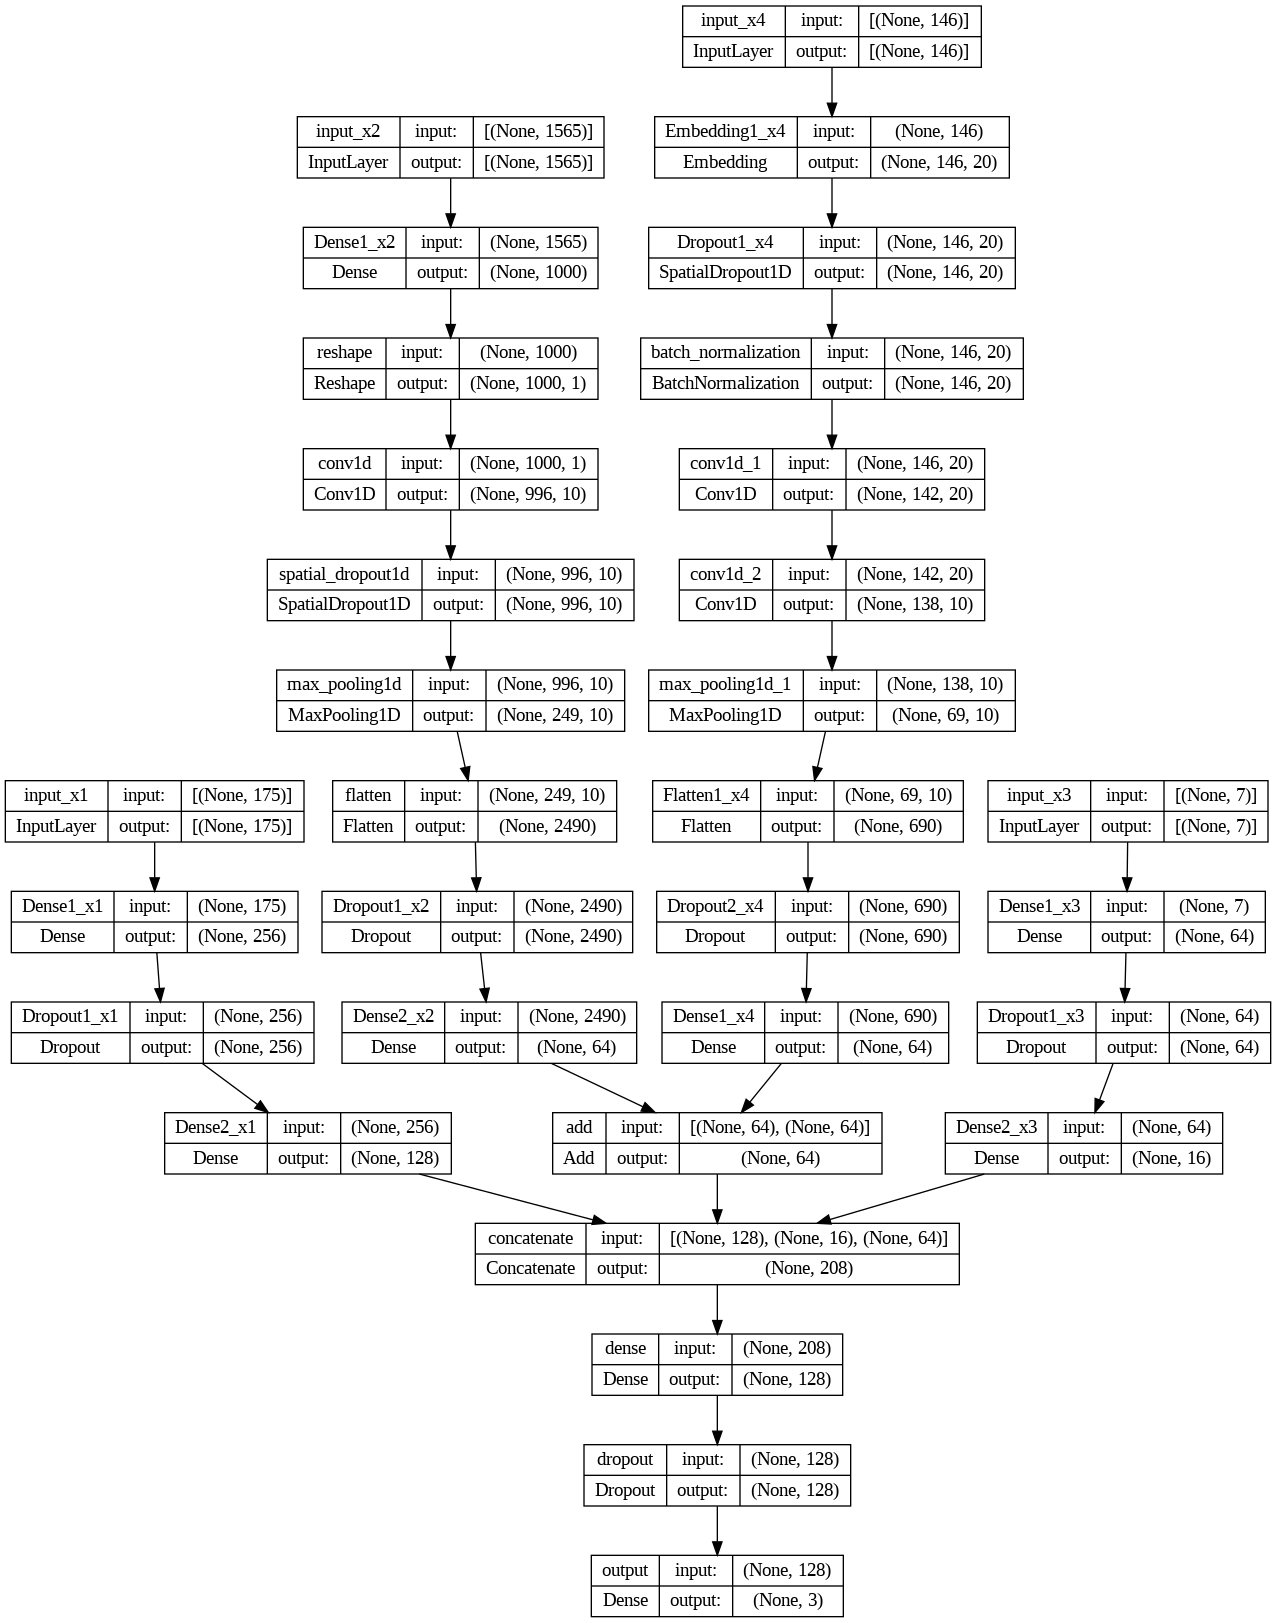

In [ ]:
# Её структура
utils.plot_model(model, show_shapes=True)

In [ ]:
# Компиляция и обучение
#model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[Precision()])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=3),'accuracy'])
history1 = model.fit({'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}, y_data, batch_size=64, validation_split=0.2, epochs=25, verbose=1)

Epoch 1/25
37/37 [==============================] - 9s 126ms/step - loss: 1.0376 - f1_score: 0.3486 - accuracy: 0.4623 - val_loss: 0.9283 - val_f1_score: 0.2176 - val_accuracy: 0.4846
Epoch 2/25
37/37 [==============================] - 4s 97ms/step - loss: 0.8606 - f1_score: 0.5336 - accuracy: 0.6093 - val_loss: 0.7573 - val_f1_score: 0.5448 - val_accuracy: 0.6952
Epoch 3/25
37/37 [==============================] - 3s 85ms/step - loss: 0.6911 - f1_score: 0.6929 - accuracy: 0.7281 - val_loss: 0.5679 - val_f1_score: 0.5760 - val_accuracy: 0.7038
Epoch 4/25
37/37 [==============================] - 3s 77ms/step - loss: 0.5132 - f1_score: 0.7960 - accuracy: 0.8049 - val_loss: 0.3995 - val_f1_score: 0.8728 - val_accuracy: 0.8887
Epoch 5/25
37/37 [==============================] - 4s 121ms/step - loss: 0.3939 - f1_score: 0.8511 - accuracy: 0.8538 - val_loss: 0.3036 - val_f1_score: 0.9014 - val_accuracy: 0.9092
Epoch 6/25
37/37 [==============================] - 4s 106ms/step - loss: 0.3113 - 

In [ ]:
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#history2 = model.fit({'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}, y_data, batch_size=32, validation_split=0.15, epochs=20, verbose=1)

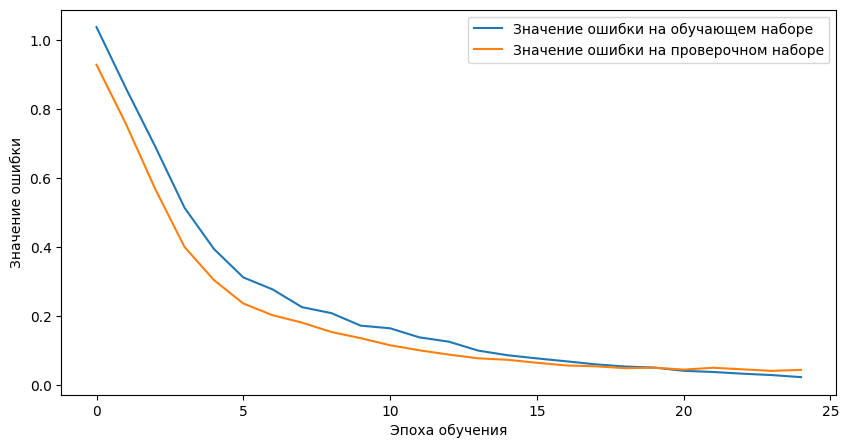

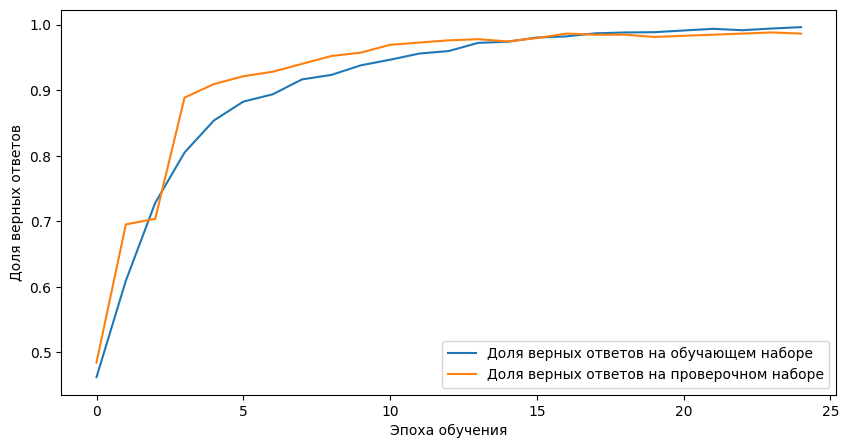

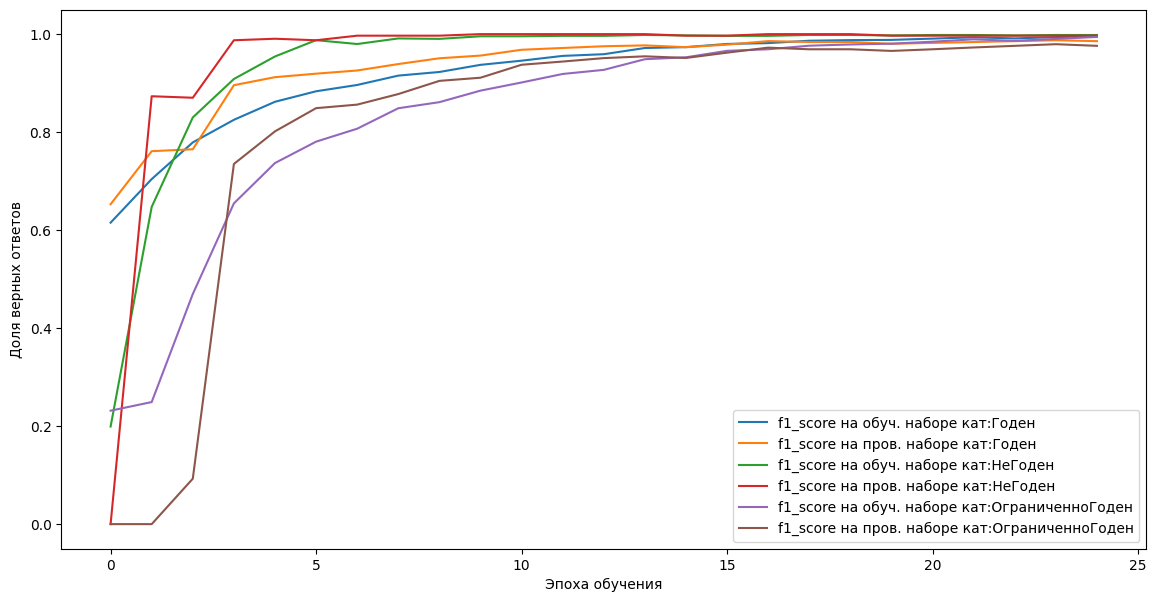

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history1.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "F1Score" по каждому классу
plt.figure(figsize = (14, 7))
for i in range(3):
    plt.plot([history1.history['f1_score'][l][i]  for l in range(len(history1.history['f1_score']))], 
             label=f'f1_score на обуч. наборе кат:{kat[i]}')
    plt.plot([history1.history['val_f1_score'][l][i]  for l in range(len(history1.history['f1_score']))], 
             label=f'f1_score на пров. наборе кат:{kat[i]}')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

1/1 [==============================] - 1s 729ms/step


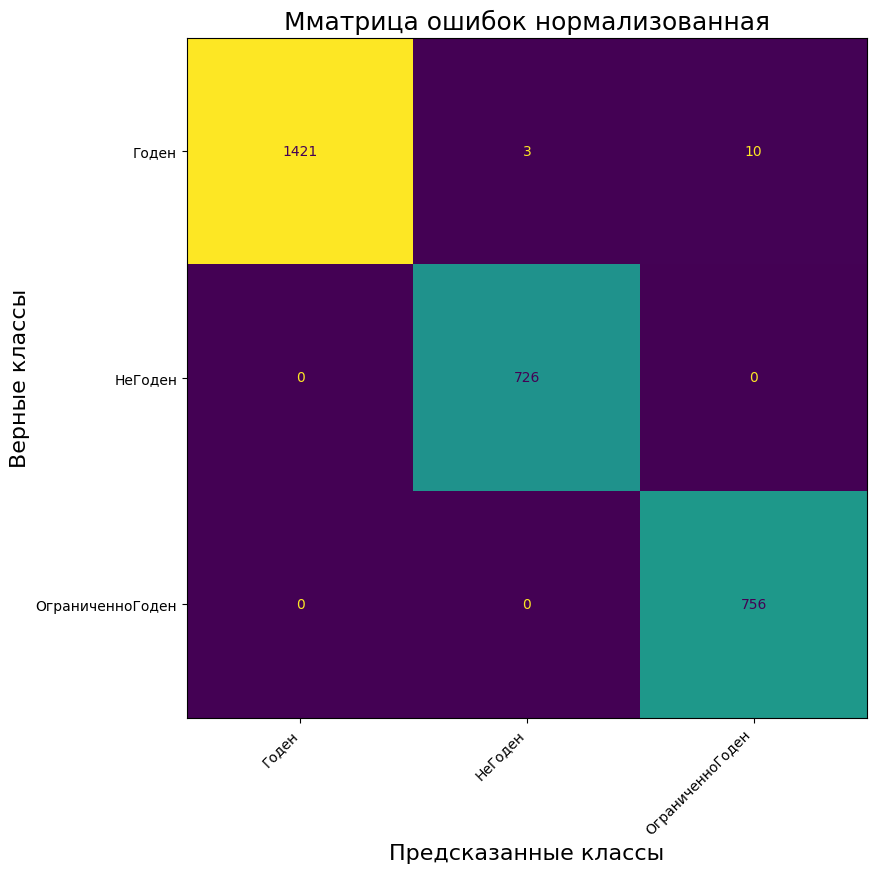

In [ ]:
# Вывод матрицы ошибок предсказания
x = {'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}
# Вычисление предсказания сети
y_pred = model.predict(x,batch_size=y_data.shape[0])
# Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_data, axis=1),
                      np.argmax(y_pred, axis=1))
# Округление значений матрицы ошибок
cm = np.around(cm, 2)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Мматрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kat)
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
plt.show()    
